# Parallelising Python code

It is sometimes stated that parallel code is difficult in Python. However, for most scientific applications, we can achieve the level of parallelism without much effort. In this notebook I will show some simple ways to get parallel code execution in Python.

1. With NumPy
2. With Joblib and multiprocessing
3. With Numba
4. With Cython

These methods range in complexity from easiest to most difficult. 

After discussing Cython, there is a short example with Numba vectorize, which can be used for functions that should be applied element-wise on numerical NumPy arrays.

## Parallel code with NumPy

By default, NumPy will dispatch the computations to an efficient BLAS (basic linear algebra subproblem) and LAPACK (Linear Algebra PACKage) implementation. BLAS and LAPACK routines are very efficient linear algebra routines that are implemented by groups of people that are experts getting as much speed as humanly possible out of the CPU, and we cannot compete with those for linear algebra computations.

A benefit and downside with NumPy is that it will likely parallelise the code for you without your knowledge. Try to compute the matrix product between two large matrices and look at your CPU load. It will likely use all of your CPU hardware threads (hardware threads are essentially cores).

## Moving the parallelism to the outer loop

Often, when we program, we have nested loops. Like below

In [1]:
x = [[] for _ in range(10)]
for i in range(10):
    for j in range(10):
        x[i].append(i*j)

for row in x:
    print(row)      

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]
[0, 4, 8, 12, 16, 20, 24, 28, 32, 36]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
[0, 6, 12, 18, 24, 30, 36, 42, 48, 54]
[0, 7, 14, 21, 28, 35, 42, 49, 56, 63]
[0, 8, 16, 24, 32, 40, 48, 56, 64, 72]
[0, 9, 18, 27, 36, 45, 54, 63, 72, 81]


Here, we have nested loop, and there are two ways to make this parallel, either by doing multiple iterations of the outer loop (`for i in range(10)`) at the same time or by doing multiple iterations of the inner loop (`for j in range(10)`) at the same time. 

Generally, we prefer to have the parallel code on the outer loop, as that is the most work per iteration, which means that there is less likelihood for our cores to stay idle. If there are more hardware threads available than there are iterations on the outer loop, we may split it up and have some of the parallelism on the inner loop as well. However, it is important to make sure that we don't try to do more things in parallel than we have hardware threads available, as otherwise, much time will be spent switching between tasks rather than actually performing the computations.

## Disabling parallel code execution in NumPy routines
Unfortunately, we have a loop where we use a NumPy function, then that function likely runs in parallel using all the available hardware threads. To avoid this from happening, we have to set some envionment variables *before* importing NumPy. Specifically, we need to set

```
OMP_NUM_THREADS=#THREADS
OPENBLAS_NUM_THREADS=#THREADS
MKL_NUM_THREADS=#THREADS
VECLIB_MAXIMUM_THREADS=#THREADS
NUMEXPR_NUM_THREADS=#THREADS
```

The first variable sets the number of OpenMP threads to `#THREADS`. OpenMP is used by many software packages that implement parallel code. The next three variables sets the number of threads for NumPy for various different BLAS backends. Finally, the last line sets the number of threads for a useful package called numexpr, which can optimise operations on the form `a*x + b*x - c`, which with pure numpy would entail four separate loops, but with numexpr is compiled to a single parallel loop.

We can either set these variables directly from Python, but then we MUST do it before any library has imported NumPy. Or, alternatively, we can set it as global environment variables. On Linux, you can add these lines to your [`~/.profile` file](https://www.quora.com/What-is-profile-file-in-Linux):

```
OPENBLAS_NUM_THREADS=1
MKL_NUM_THREADS=1
VECLIB_MAXIMUM_THREADS=1
NUMEXPR_NUM_THREADS=1
```

Notice how we did not set the number of OpenMP threads to 1 in the `~/.profile` file, as that would likely disable parallelism for most programs that use OpenMP for parallel code execution.

**Note that if we set `OMP_NUM_THREADS` to 1, then parallelism with Numba and Cython will not work.**

In [2]:
import os

def set_threads(
    num_threads,
    set_blas_threads=True,
    set_numexpr_threads=True,
    set_openmp_threads=False
):
    num_threads = str(num_threads)
    if not num_threads.isdigit():
        raise ValueError("Number of threads must be an integer.")
    if set_blas_threads:
        os.environ["OPENBLAS_NUM_THREADS"] = num_threads
        os.environ["MKL_NUM_THREADS"] = num_threads
        os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
    if set_numexpr_threads:
        os.environ["NUMEXPR_NUM_THREADS"] = num_threads
    if set_openmp_threads:
        os.environ["OMP_NUM_THREADS"] = num_threads

set_threads(1)

Now, we can import numpy to our code and it will only run on only one core.

In [3]:
import numpy as np

## Parallel code with Joblib and multiprocessing

Python does not support parallel threading. This means that each Python process can only do one thing at a time. The reason for this lies with the way Python code is run on your computer. Countless hours has been spent trying to remove this limitation, but all sucessfull attempts severly impaired the speed of the language (the most well known attempt is Larry Hasting's [gilectomy](https://github.com/larryhastings/gilectomy)). 

Since we cannot run code in parallel within a single process, we need to start new processes for each task we wish to compute in parallel and send the relevant information to these processes. This leads to a lot of overhead, and if we hope to have any performance gain, then we should parallelise substantial tasks if we wish to do it with multiple processes.

### The best approach: Joblib

The best approach to multiprocessing in Python is through the Joblib library. It overcomes some of the shortcomings of multiprocessing (that you may not realise is a problem until you encounter them) at the cost of an extra dependency in your code. Below, we see an example of parallel code with joblib

In [4]:
from joblib import Parallel, delayed

def f(x):
    return x + 2

numbers1 = Parallel(n_jobs=2)(delayed(f)(x) for x in range(10))

print(numbers1)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Here we see how Joblib can help us parallelise simple for loops. We wrap what we wish to compute in a function and use it in a list comprehension. The `n_jobs` argument specifies how many processes to spawn. If it is a positive number (1, 2, 4, etc.) then it is the number of processes to spawn and if it is a negative number then joblib will spawn (n_cpu_threads + 1 - n_processes). Thus `n_jobs=-1` will spawn as many processes as there are CPU threads available, `n_jobs=-2` will spawn n-1 CPU threads, etc. 

I recommend setting `n_jobs=-2` so you have one CPU thread free to surf the web while you run hard-core experiments on your computer.

In [5]:
numbers1 = Parallel(n_jobs=-2)(delayed(f)(x) for x in range(10))

print(numbers1)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


If we cannot wrap all the logic within a single function, but need to have two separate parallel loops, then we should use the `Parallel` object in a slightly different fashion. If we do the following:

In [6]:
from joblib import Parallel, delayed

def f(x):
    return x + 2

numbers1 = Parallel(n_jobs=2)(delayed(f)(x) for x in range(10))
numbers2 = Parallel(n_jobs=2)(delayed(f)(x) for x in range(20))


print(numbers1)
print(numbers2)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


Then we will first create two new Python processes, compute the parallel list comprehension, close these two processess before spawning two new Python processes and computing the second parallel list comprehension. This is obviously not ideal, and we can reuse the pool of processes with a context manager:

In [7]:
with Parallel(n_jobs=2) as parallel:
    numbers1 = parallel(delayed(f)(x) for x in range(10))
    numbers2 = parallel(delayed(f)(x) for x in range(20))

print(numbers1)
print(numbers2)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


Here, the same processes are used for both list comprehensions!

## Async operations with multiprocessing
An alternative to using Joblib for multiprocessing in Python is to use the builtin `multiprocessing` module.
This module is not as user friendly as joblib, and may break with weird error messages. 

In [8]:
import multiprocessing

def add_2(x):
    return x + 2

with multiprocessing.Pool(4) as p:
    print(p.map(add_2, range(10)))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Here, we see that multiprocessing also requires us to wrap the code we wish to run in parallel in a function. 

However, one particular of multiprocessing is that it requires all inputs to be picklable. That means that we cannot use output a factory function and you may also have problems with using multiprocessing with instance methods. Below is an example that fails.

In [9]:
import multiprocessing

def add(x):
    def add_x(y):
        return x + y
    return add_x

add_2 = add(2)
print(add_2(2))

with multiprocessing.Pool(4) as p:
    p.map(add_2, range(10))

4


AttributeError: Can't pickle local object 'add.<locals>.add_x'

We see that local functions aren't picklable, however, the same code runs with joblib:

In [10]:
print(Parallel(n_jobs=4)(delayed(add_2)(x) for x in range(10)))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


### So why use multiprocessing?
Unfortunately, Joblib blocks the python interpreter, so that while the other processess run, no work can be done on the mother process. See the example below:

In [11]:
from time import sleep, time

def slow_function(x):
    sleep(3)
    return x

start_time = time()
Parallel(n_jobs=-2)(delayed(slow_function)(i) for i in range(10))
print(time() - start_time)

6.969935655593872


Meanwhile, with multiprocessing, we can start the processes, let those run in the background, and do other tasks while waiting. Here is an example

In [12]:
with multiprocessing.Pool(6) as p:
    # Start ten processes.
    # The signature for the apply_async method is as follows
    # apply_async(function, args, kwargs)
    # the args iterable is fed into the function using tuple unpacking
    # the kwargs iterable is fed into the function using dictionary unpacking
    tasks = [p.apply_async(slow_function, [i]) for i in range(10)]

    prev_ready = 0
    num_ready = sum(task.ready() for task in tasks)
    while num_ready != len(tasks):
        if num_ready != prev_ready:
            print(f"{num_ready} out of {len(tasks)} completed tasks")
        prev_ready = num_ready
        num_ready = sum(task.ready() for task in tasks)
    results = [task.get() for task in tasks]
print(results)

1 out of 10 completed tasks
2 out of 10 completed tasks
5 out of 10 completed tasks
6 out of 10 completed tasks
7 out of 10 completed tasks
8 out of 10 completed tasks
9 out of 10 completed tasks
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


This means that, if you have to do some post processing of the output of the parallel loop, then you can start doing that with the elements that are done. Here is a very simple example

In [13]:
with multiprocessing.Pool(6) as p:
    # Start ten processes.
    # The signature for the apply_async method is as follows
    # apply_async(function, args, kwargs)
    # the args iterable is fed into the function using tuple unpacking
    # the kwargs iterable is fed into the function using dictionary unpacking
    tasks = [p.apply_async(slow_function, [i]) for i in range(10)]

    finished = {}
    while len(finished) != len(tasks):
        for i, task in enumerate(tasks):
            if task.ready():
                if i not in finished:
                    print(f"Task {i} just finished, its result was {task.get()}")
                finished[i] = task.get()

print([finished[i] for i in range(10)])

Task 0 just finished, its result was 0
Task 1 just finished, its result was 1
Task 2 just finished, its result was 2
Task 3 just finished, its result was 3
Task 4 just finished, its result was 4
Task 5 just finished, its result was 5
Task 6 just finished, its result was 6
Task 7 just finished, its result was 7
Task 8 just finished, its result was 8
Task 9 just finished, its result was 9
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Parallelising with Numba

Numba is a magical tool that will let us write Python code that is just in time compiled (JIT) to machine code using LLVM. This means that we can get C-speed with our Python code!

Unfortunately, the price of this black magic is that Numba doesn't support the whole Python language. Rather, it supports a subset of it. Especially if you enable `nopython` mode (doing work outside the Python virtual machine) to get the best speedups.

Let us start by looking at some simple non-parallel Numba tricks

In [14]:
import numba

def python_sum(A):
    s = 0
    for i in range(A.shape[0]):
        s += A[i]

    return s

@numba.jit
def numba_normal_sum(A):
    s = 0
    for i in range(A.shape[0]):
        s += A[i]

    return s

In [15]:
x = np.random.randn(10000)
print("Pure python")
%timeit python_sum(x)
print("Numba")
%timeit numba_normal_sum(x)

Pure python
2.09 ms ± 31.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Numba
10.5 µs ± 254 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


We see that the numba compiled code is much faster than the plain python code (more than x100). The downside with writing code this way is that error messages are cryptic  and a function that is JIT compiled can only call a subset of all Python, NumPy and SciPy functions in addition to other JIT compiled functions. See the documentation for more info on this.

However, we can also parallelise code with Numba, using the `numba.prange` (parallel range) function. This code is cheekily stolen from the [documentation](https://numba.pydata.org/numba-doc/0.11/prange.html)

In [16]:
@numba.jit(parallel=True, nogil=True)
def numba_parallel_sum(A):
    s = 0
    for i in numba.prange(A.shape[0]):
        s += A[i]

    return s

In [17]:
x = np.random.randn(10000)
numba_normal_sum(x)  # compile it once
numba_parallel_sum(x)  # compile it once
print("Pure python")
%timeit python_sum(x)
print("\nNumba")
%timeit numba_normal_sum(x)
print("\nParallel Numba")
%timeit numba_parallel_sum(x)

Pure python
2.09 ms ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Numba
10.4 µs ± 97.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Parallel Numba
28.7 µs ± 462 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Here, we see that the performance actually deteriorates by parallising the code! This is because of the extra overhead needed to organise multiple workers. However, sometimes parallelising code this way can lead to significant speedups (especially if each iteration is costly).

We can use Cython to reduce the overhead that we experience with the parallel sum.

**Note:** It is difficult to use Numba on the outer loop, so if you have costly outer loops, then you should use Joblib to have the parallelism there instead.

## Parallel code with Cython
Finally, we look at Cython to optimise and paralellise code. Cython is a language that will let us write Python-like code that is transpiled into a Python C extension. This means several things:

1. We can get C speed without much effort
2. Cython is a superset of Python, so any Python code can be compiled
3. It is easier to write Cython, but it requires manual compilation.

The first two points here make Cython a very attractive alternative. However, the final point can be very problematic. Whenever you make a change to a Cython file, you need to compile it again. This is generally done via a `setup.py` file that contains build instructionsf for your Cython files.

Luckily, we can prototype some Cython code in a notebook, using the `%%cython` magic command.

In [18]:
%load_ext Cython

The code below is just copy pasted from above, but the inclusion of the `%%cython` cell magic means that the code is now compiled and can run faster its pure Python counterpart. Just copy pasting code this way will not massively improve runtime.

In [19]:
%%cython
import numpy as np

def cython_sum(A):
    s = 0
    for i in range(A.shape[0]):
        s += A[i]

    return s

Unfortunately, the code above is sill running in the CPython virtual machine which are a lot slower than a pure C function. Let us fix this, to do that, we avoid any Python data types, and only use the C counterparts.

In [20]:
%%cython
cimport cython
cimport numpy as np
import numpy as np

@cython.boundscheck(False)  # Do not check if Numpy indexing is valid
@cython.wraparound(False)   # Deactivate negative Numpy indexing.
cpdef smart_cython_sum(np.ndarray[np.float_t] A):  
# ^ Notice cpdef instead of def. Define it as a C function and Python function simultaneously.
    cdef float s = 0
    cdef int i
    for i in range(A.shape[0]):
        s += A[i]

    return s

Now, we can look at how to make this run in parallel. To do this, we need OpenMP (which runs a bit differently on linux and windows).

In [21]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force
from cython.parallel import prange
import numpy as np

cimport cython
cimport numpy as np
cimport openmp


@cython.boundscheck(False)  # Do not check if Numpy indexing is valid
@cython.wraparound(False)   # Deactivate negative Numpy indexing.
cpdef parallel_cython_sum(np.ndarray[np.float_t] A):  
# ^ Notice cpdef instead of def. Define it as a C function and Python function simultaneously.
    cdef float s = 0
    cdef int i
    for i in prange(A.shape[0], nogil=True, num_threads=8):
        s += A[i]


    return s


In [22]:
x = np.random.randn(10000)
print("Pure python")
%timeit python_sum(x)
print("\nNumba")
%timeit numba_normal_sum(x)
print("\nParallel Numba")
%timeit numba_parallel_sum(x)
print("\nNaive Cython")
%timeit cython_sum(x)
print("\nSmart Cython")
%timeit smart_cython_sum(x)
print("\nParallel Cython")
%timeit parallel_cython_sum(x)

Pure python
2.25 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Numba
10.6 µs ± 108 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Parallel Numba
33.3 µs ± 2.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Naive Cython
2.47 ms ± 88.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Smart Cython
44.4 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Parallel Cython
14.4 µs ± 3.55 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


From this, we see a couple of things

 1. There is little difference between pure Python and naive Cython
 2. Pure Numba is faster than sophisticated Cython for this example
 3. The parallel code in Cython has much less overhead than the parallel code in Numba
 
In general, it is difficult to say if Numba or Cython will be fastest. The reason for this is that Numba may or may not be able to lift the CPython virtual machine. If it isn't able to do so, it will often be much slower than Cython.

Thus, if Numba works, it is often as good as, if not better than Cython. You should therefore start with Numba, and if that doesn't provide a good enough speed up, then you can try Cython.

Long functions are often easier to implement in Cython and small ones are often best implemented in Numba. A big downside with Cython (that cannot be stressed enough) is that it adds huge overhead for building and distributing the code. I therefore discourage the use of Cython for code that will be made public unless all other options are tested first.

## Vectorisation with Numba
Finally, we will look at vectorisation of functions with Numba. Vectorisation is when we wish to apply the same function to all elements of an array. For example, the `exp` function in NumPy is a vectorised function.

Let us create a vectorised function to compute the Mandelbrot set. 

In [23]:
@np.vectorize
def compute_mandelbrot_np(x):
    C = x
    for i in range(20):
        if abs(x) >= 4:
            return i

        x = x**2 + C
    return -1


@numba.vectorize([numba.int32(numba.complex128)], target="cpu")
def compute_mandelbrot_cpu(x):
    C = x
    for i in range(20):
        if abs(x) >= 4:
            return i

        x = x**2 + C
    return -1

@numba.vectorize([numba.int32(numba.complex128)], target="parallel")
def compute_mandelbrot_parallel(x):
    C = x
    for i in range(20):
        if abs(x) >= 4:
            return i

        x = x**2 + C
    return -1

In [24]:
X = -0.235
Y = 0.827
R = 4.0e-1

x = np.linspace(X - R, X + R, 100)
y = np.linspace(Y - R, Y + R, 100)

xx, yy = np.meshgrid(x, y)
zz = xx + 1j*yy

compute_mandelbrot_cpu(zz)  # Compile once
compute_mandelbrot_parallel(zz)  # Compile once
print("Single core NumPy")
%timeit compute_mandelbrot_np(zz)
print("Single core Numba")
%timeit compute_mandelbrot_cpu(zz)
print("Multi core Numba")
%timeit compute_mandelbrot_parallel(zz)

Single core NumPy
10.5 ms ± 3.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Single core Numba
421 µs ± 41.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Multi core Numba
396 µs ± 224 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Here, we see not only the effect of just in time compiling our function but also that all our CPU cores are fully utilised when vectorizing functions! Let us plot a section of the mandelbrot set!

In [25]:
import matplotlib.pyplot as plt

In [26]:
%config InlineBackend.figure_format = 'retina'

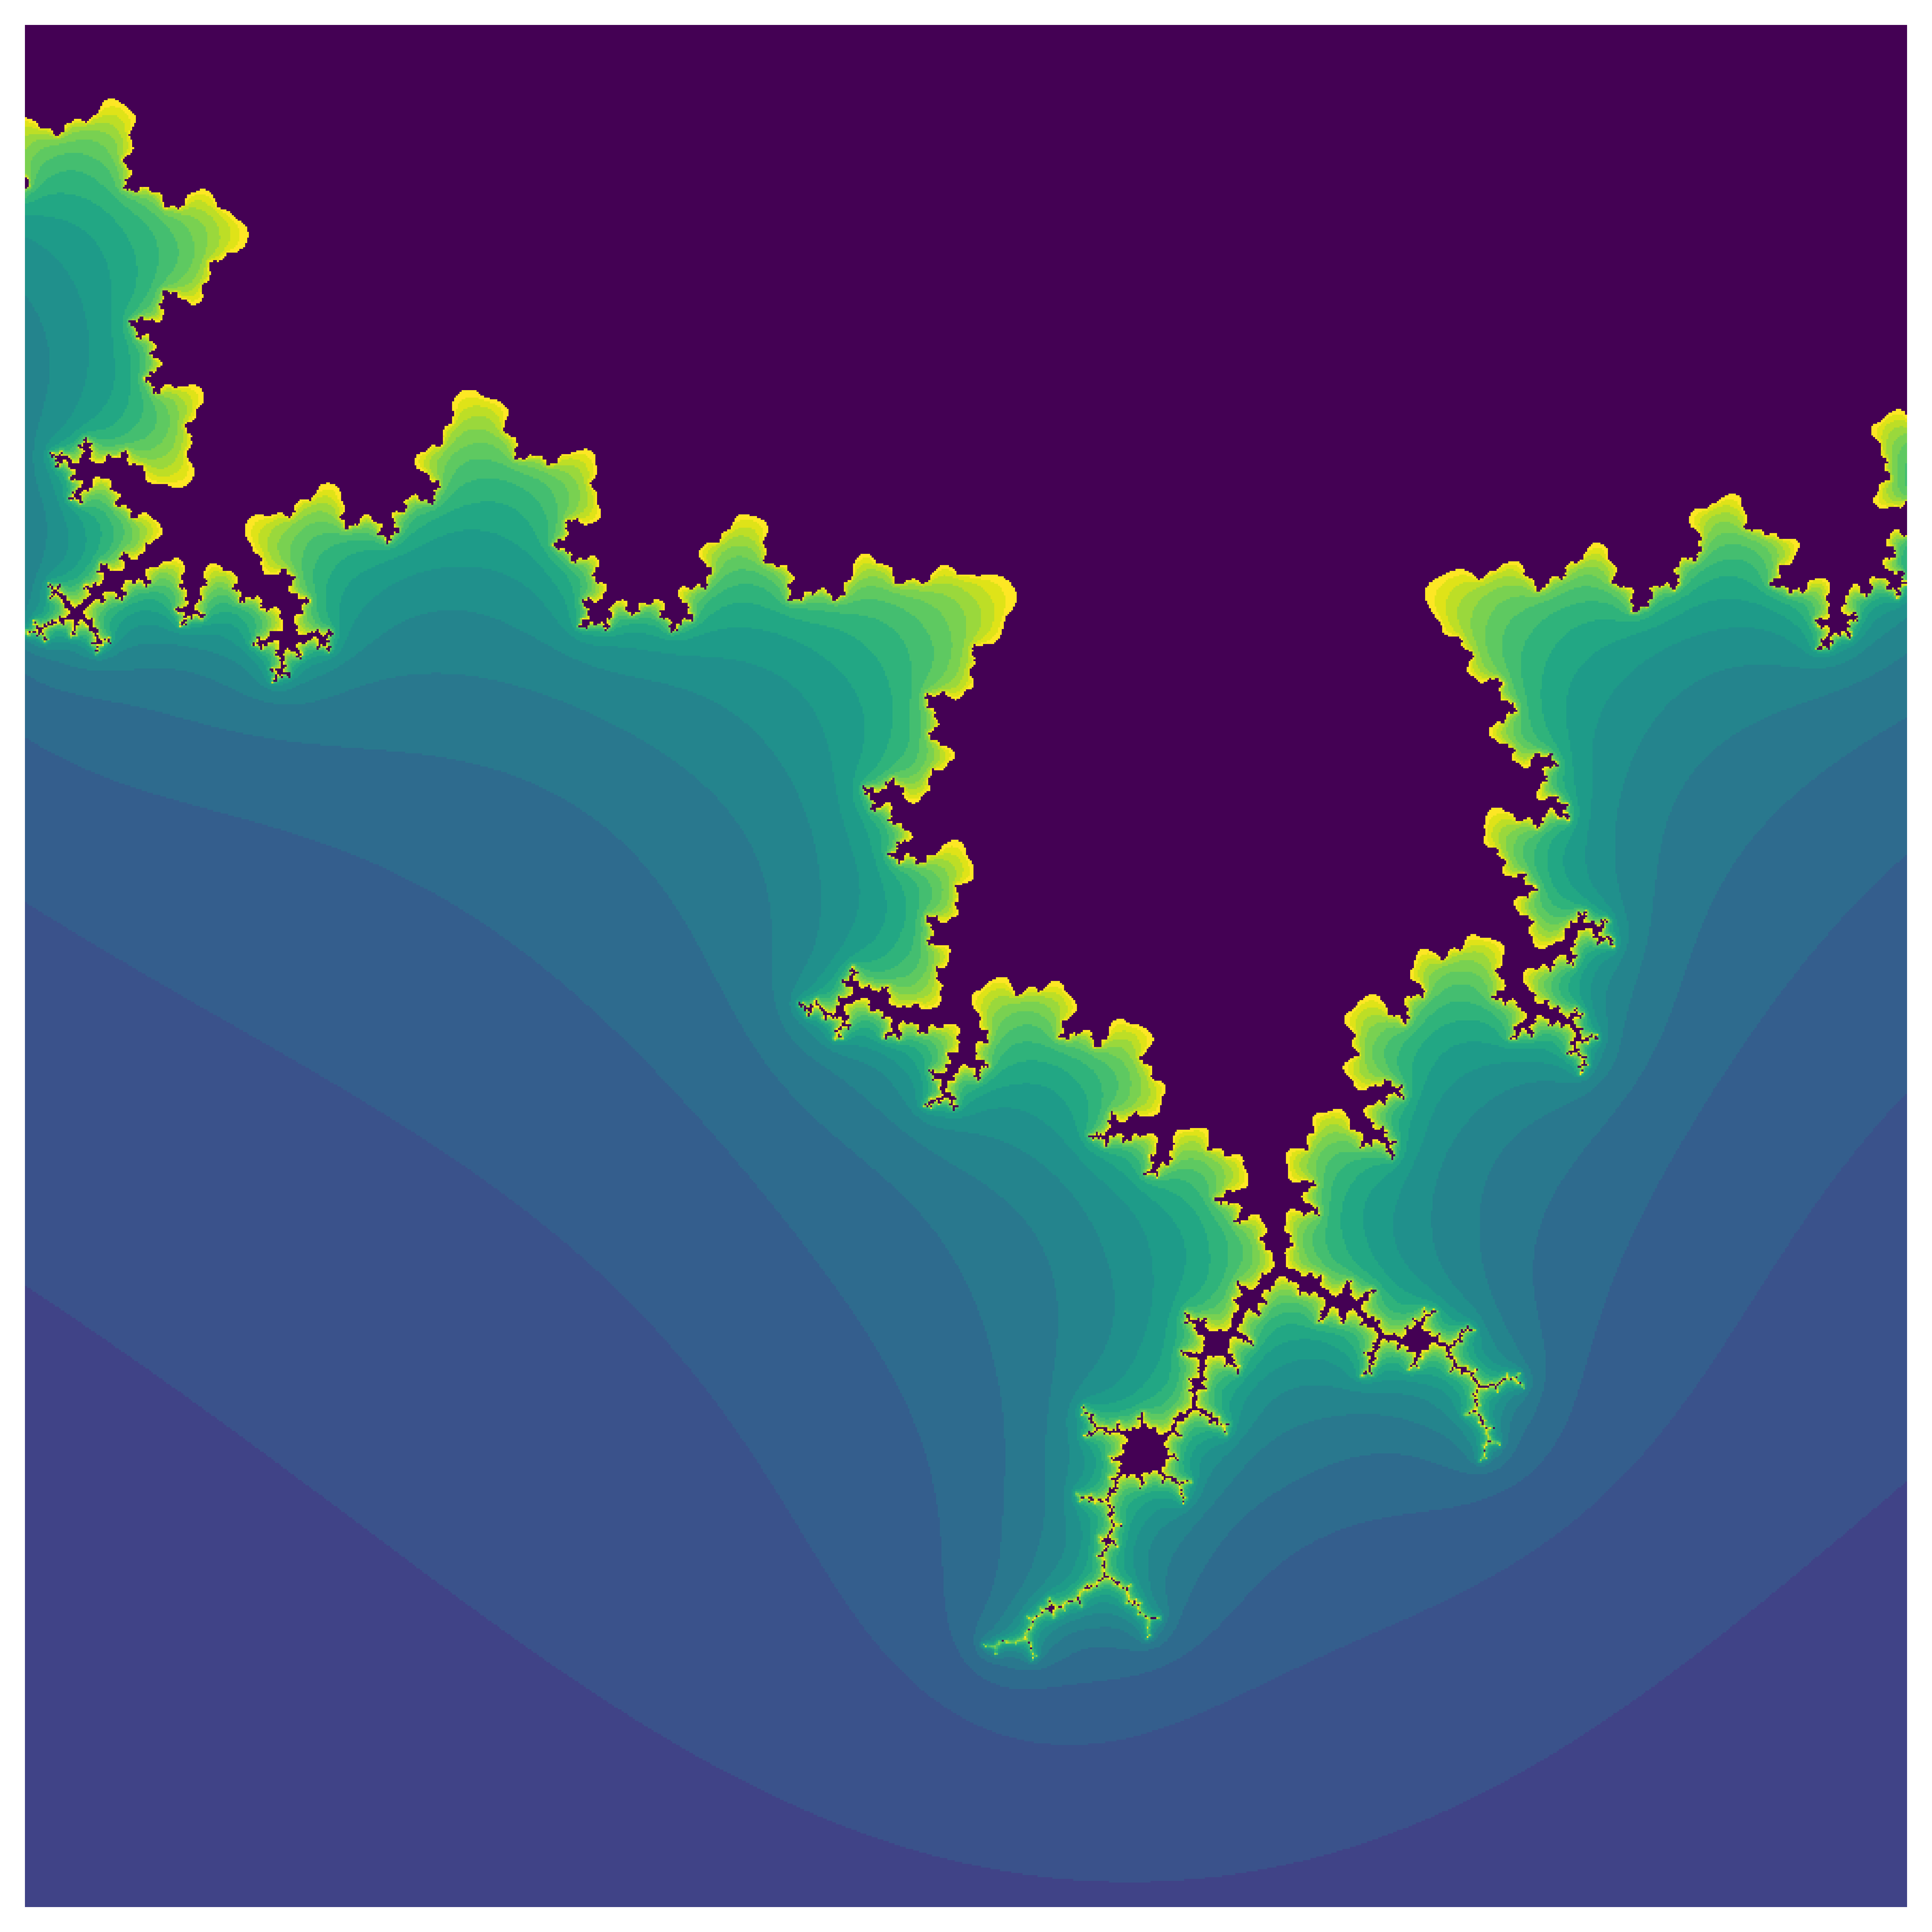

In [27]:
X = -0.235
Y = 0.827
R = 4.0e-1

x = np.linspace(X - R, X + R, 1000)
y = np.linspace(Y - R, Y + R, 1000)

xx, yy = np.meshgrid(x, y)
zz = xx + 1j*yy
mandelbrot = compute_mandelbrot_parallel(zz)

plt.figure(figsize=(10, 10), dpi=300)
plt.imshow(mandelbrot)
plt.axis('off')
plt.show()